<a href="https://colab.research.google.com/github/oraziotorre/TTinsight/blob/main/TTinsight_DataPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TTinsight


---


## Data Preprocessing, Feature Engineering e Model Development

In questo notebook vedremo tutto il processo per il caricamento, l'analisi e la pulizia dei dati. Sceglieremo poi le feature migliori e addestreremo un classificatore binario.

Vogliamo addrestrare un modello che predica la probabilità di "W" nella colonna matcht result

# **Inizializzazione**

In [ ]:
# Importazioni necessarie per il lavoro con i dati e il machine learning

# Pandas per la gestione dei dati
import pandas as pd
import numpy as np
from collections import Counter
import ast
import math
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import concatenate
# Per la preparazione e la divisione dei dati
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

#Per il k-fold cross validation
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler


# Keras per il preprocessing delle sequenze
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

# Deep Learning con TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Masking, Embedding, Dropout

# Per visualizzare i DataFrame su Google Colab in formato tabellare
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [ ]:
dataset = pd.read_csv("raw_dataset.csv")

dataset

,event_id,match_id,match_format,players_gender,match_stage,stage_id,match_duration,match_start_time,player_id,player_2_id,opponent_id,opponent_2_id,player_sets_won,opponent_sets_won,match_scores,sets_required_to_win,current_match_state,player_points,opponent_points
0,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,FNL,100,1990,2021-11-15 17:32:48,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8",3,0-0,"[0, 0, 1, 2, 2, 3, 4, 4, 4, 5, 6, 6, 6, 6, 6, ...","[1, 2, 2, 2, 3, 3, 3, 4, 5, 5, 5, 6, 7, 8, 9, ..."
1,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,FNL,100,1990,2021-11-15 17:32:48,117294,109777.0,112463,115009.0,2,3,"11-8,8-11,9-11,11-7,8-11",3,0-0,"[1, 2, 2, 2, 3, 3, 3, 4, 5, 5, 5, 6, 7, 8, 9, ...","[0, 0, 1, 2, 2, 3, 4, 4, 4, 5, 6, 6, 6, 6, 6, ..."
2,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,FNL,100,1990,2021-11-15 17:32:48,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8",3,0-1,"[1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 9, 9, ...","[0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 6, ..."
3,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,FNL,100,1990,2021-11-15 17:32:48,117294,109777.0,112463,115009.0,2,3,"11-8,8-11,9-11,11-7,8-11",3,1-0,"[0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 6, ...","[1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 9, 9, ..."
4,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,FNL,100,1990,2021-11-15 17:32:48,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8",3,1-1,"[1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 6, 6, 6, 7, ...","[0, 1, 1, 2, 3, 3, 4, 4, 5, 5, 5, 6, 7, 8, 8, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144189,2997,TTEMSINGLES-----------RND2000600----------,S,M,RND2,600,2452,2024-10-29 13:45:00,137238,NaN,132172,NaN,3,2,"11-3,7-11,11-9,7-11,11-6",3,1-1,"[0, 1, 1, 2, 2, 3, 4, 4, 4, 5, 5, 6, 6, 7, 8, ...","[1, 1, 2, 2, 3, 3, 3, 4, 5, 5, 6, 6, 7, 7, 7, ..."
144190,2997,TTEMSINGLES-----------RND2000600----------,S,M,RND2,600,2452,2024-10-29 13:45:00,132172,NaN,137238,NaN,2,3,"3-11,11-7,9-11,11-7,6-11",3,1-2,"[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ...","[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ..."
144191,2997,TTEMSINGLES-----------RND2000600----------,S,M,RND2,600,2452,2024-10-29 13:45:00,137238,NaN,132172,NaN,3,2,"11-3,7-11,11-9,7-11,11-6",3,2-1,"[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ...","[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ..."
144192,2997,TTEMSINGLES-----------RND2000600----------,S,M,RND2,600,2452,2024-10-29 13:45:00,132172,NaN,137238,NaN,2,3,"3-11,11-7,9-11,11-7,6-11",3,2-2,"[1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 5, 5, 5, 6, 6]","[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9, 9, 10]"


# **Etichettatura**

Il dataset avrà una nuova colonna ```set_result``` che conterrà il risultato del set per ogni partita:

- **1** per la classe **Vincitori** del set
- **0** per la classe **Sconfitti** del set

Questo tipo di etichettatura è utile per i nostri LSTM e Regressione Logistica, dove l'obiettivo sarà quello di prevedere se un giocatore vincerà o perderà un set sulla base di altre informazioni.


In [ ]:
# Funzione per convertire i punteggi da stringa a lista di interi
def convert_to_int_list(points_str):
    # Verifica che la stringa sia valida
    if isinstance(points_str, str):
        # Rimuove le parentesi quadre e suddivide la stringa per ottenere i numeri
        return list(map(int, points_str.strip('[]').split(', ')))
    else:
        return None


# Funzione per determinare il risultato del set
def calculate_set_result(player_points, opponent_points):
    if player_points:
        if player_points[-1] > opponent_points[-1]:
            return 1  # Vittoria per il giocatore
        else:
            return 0  # Sconfitta per il giocatore
    else:
        return -1  # Dati non conformi

# Inizializzo una lista vuota per la nuova colonna con le etichette
set_results = []

# Trasformo i punteggi in liste di interi utilizzando la funzione definita
dataset['player_points'] = dataset['player_points'].apply(convert_to_int_list)
dataset['opponent_points'] = dataset['opponent_points'].apply(convert_to_int_list)

# Itero su ogni riga e dai punteggi definisce l'etichetta
for index, row in dataset.iterrows():
    result = calculate_set_result(row['player_points'], row['opponent_points'])
    set_results.append(result)

# Aggiungo la nuova colonna 'set_result' al DataFrame
dataset['set_result'] = set_results

# Visualizzo il risultato
dataset




,event_id,match_id,match_format,players_gender,match_stage,stage_id,match_duration,match_start_time,player_id,player_2_id,opponent_id,opponent_2_id,player_sets_won,opponent_sets_won,match_scores,sets_required_to_win,current_match_state,player_points,opponent_points,set_result
0,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,FNL,100,1990,2021-11-15 17:32:48,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8",3,0-0,"[0, 0, 1, 2, 2, 3, 4, 4, 4, 5, 6, 6, 6, 6, 6, ...","[1, 2, 2, 2, 3, 3, 3, 4, 5, 5, 5, 6, 7, 8, 9, ...",0
1,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,FNL,100,1990,2021-11-15 17:32:48,117294,109777.0,112463,115009.0,2,3,"11-8,8-11,9-11,11-7,8-11",3,0-0,"[1, 2, 2, 2, 3, 3, 3, 4, 5, 5, 5, 6, 7, 8, 9, ...","[0, 0, 1, 2, 2, 3, 4, 4, 4, 5, 6, 6, 6, 6, 6, ...",1
2,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,FNL,100,1990,2021-11-15 17:32:48,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8",3,0-1,"[1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 9, 9, ...","[0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 6, ...",1
3,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,FNL,100,1990,2021-11-15 17:32:48,117294,109777.0,112463,115009.0,2,3,"11-8,8-11,9-11,11-7,8-11",3,1-0,"[0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 6, ...","[1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 9, 9, ...",0
4,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,FNL,100,1990,2021-11-15 17:32:48,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8",3,1-1,"[1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 6, 6, 6, 7, ...","[0, 1, 1, 2, 3, 3, 4, 4, 5, 5, 5, 6, 7, 8, 8, ...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144189,2997,TTEMSINGLES-----------RND2000600----------,S,M,RND2,600,2452,2024-10-29 13:45:00,137238,NaN,132172,NaN,3,2,"11-3,7-11,11-9,7-11,11-6",3,1-1,"[0, 1, 1, 2, 2, 3, 4, 4, 4, 5, 5, 6, 6, 7, 8, ...","[1, 1, 2, 2, 3, 3, 3, 4, 5, 5, 6, 6, 7, 7, 7, ...",1
144190,2997,TTEMSINGLES-----------RND2000600----------,S,M,RND2,600,2452,2024-10-29 13:45:00,132172,NaN,137238,NaN,2,3,"3-11,11-7,9-11,11-7,6-11",3,1-2,"[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ...","[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ...",1
144191,2997,TTEMSINGLES-----------RND2000600----------,S,M,RND2,600,2452,2024-10-29 13:45:00,137238,NaN,132172,NaN,3,2,"11-3,7-11,11-9,7-11,11-6",3,2-1,"[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ...","[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ...",0
144192,2997,TTEMSINGLES-----------RND2000600----------,S,M,RND2,600,2452,2024-10-29 13:45:00,132172,NaN,137238,NaN,2,3,"3-11,11-7,9-11,11-7,6-11",3,2-2,"[1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 5, 5, 5, 6, 6]","[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9, 9, 10]",0


# **Analisi dei dati**


## Controllo del bilanciamento dei dati
Una delle prime cose che possiamo verificare è se il dataset sia **bilanciato**. Per cui, controlliamo il numero di istanze **1** e **0** della colonna *set_result*

In [ ]:
# Numero di elementi per la classe "Vincitori"
print(len(dataset[(dataset['set_result'] == 1)]))
# Numero di elementi per la classe "Sconfitti"
print(len(dataset[(dataset['set_result'] == 0)]))

# Totale
print(len(dataset))


69607
69607
144194


Notiamo che abbiamo un dataset non troppo sbilanciato

## **Analisi delle caratteristiche e delle distribuzioni dei dati**
Usiamo `describe()` per avere una overview sulle distribuzioni dei dati numerici

In [ ]:
# Verifico la correttezza dei campi numerici
dataset.describe()

,event_id,stage_id,match_duration,player_id,player_2_id,opponent_id,opponent_2_id,player_sets_won,opponent_sets_won,sets_required_to_win,set_result
count,144194.000000,144194.000000,144194.000000,144194.000000,35116.000000,144194.000000,35116.000000,144194.000000,144194.000000,144194.000000,144194.000000
mean,2702.487149,1556.146095,2058.918221,123836.818280,125800.822332,123836.818280,125800.822332,2.086800,2.086800,3.146705,0.448195
std,156.933844,5453.961129,1575.253127,17169.115984,17804.203785,17169.115984,17804.203785,1.250522,1.250522,0.353970,0.562487
min,2234.000000,100.000000,0.000000,90051.000000,100001.000000,90051.000000,100001.000000,0.000000,0.000000,2.000000,-1.000000
25%,2569.000000,200.000000,1426.000000,114715.000000,115565.000000,114715.000000,115565.000000,1.000000,1.000000,3.000000,0.000000
50%,2701.000000,600.000000,1914.000000,121403.000000,122428.000000,121403.000000,122428.000000,3.000000,3.000000,3.000000,0.000000
75%,2869.000000,1200.000000,2430.000000,132081.000000,133124.000000,132081.000000,133124.000000,3.000000,3.000000,3.000000,1.000000
max,2997.000000,110005.000000,77074.000000,212088.000000,212090.000000,212088.000000,212090.000000,5.000000,5.000000,5.000000,1.000000


Notiamo che nella colonna "set_required_to_win" sono presenti dei valori rari non nel nostro interesse (2 e 5)

## **Controllo dei valori nulli**

Verifico i valori mancanti nei dati

In [ ]:
# Identificare i valori NaN nel dataset
nan_mask = dataset.isna()

# Conta i valori NaN (valori mancanti) per ciascuna colonna del dataset
nan_count = nan_mask.sum()

# Verifico i valori null del raw_dataset
nan_count


,0
event_id,0
match_id,0
match_format,0
players_gender,0
match_stage,0
stage_id,0
match_duration,0
match_start_time,0
player_id,0
player_2_id,109078


#**Operazione sulle feature**


Facciamo alcune considerazioni sulle caratteristiche del nostro dataset e identifichiamo possibili **miglioramenti** per ottimizzarlo in vista del prossimo training del modello:

* Possibile **trasformare i formati T** nella colonna ```match_format``` in formati che siano o S o D

* La colonna ```match_stage``` può essere modificata per attribuire **maggiore importanza alle partite finali** (FNL) rispetto a tutte le altre, migliorando il peso di queste informazioni nel training del modello.

* Le colonne ```sets_required_to_win``` e ```current_match_state``` fanno entrambe riferimento al numero di set necessari per vincere una partita. Per rendere il dataset più chiaro e organizzato, possiamo **sostituirle** con due nuove colonne: ```sets_to_win``` e ```opponent_sets_to_win```, che rappresentano rispettivamente il numero di set necessari al giocatore e all'avversario per vincere la partita.

* Per la colonna ```players_gender``` si può semplificare il formato tramite l'operazione di ***One-Hot Encoding*** nel caso di dataset_all_matches o tramite una semplice codifica binaria nel caso del dataset_single_matches

*  Le colonne ```match_format```, ```player_id```, ```player_2_id``` **non sono necessarie** per il training del modello e possono essere cancellate




# **Colonna *match_format***

Modifica la colonna *match_format*, sostituendo tutti i valori ' T ' (partita di team) con ' S ' (partita di singolo) o ' D ' (partita di doppio)

Viene eseguita questa operazione per **evitare la rimozione di valori** che potrebbero ritornarci utile successivamente nello sviluppo del nostro modello

In [ ]:
# Funzione per determinare il match_format quando è Team (Singolo o Doppio)
def determine_match_format(player_2_id):
    # Controlla se il valore di player_2_id è NaN (valore mancante)
    if pd.isna(player_2_id):
        return 'S'  # Ritorna 'S' per indicare una partita singola
    else:
        return 'D'  # Ritorna 'D' per indicare una partita doppia

# Applica la funzione determine_match_format alla colonna 'player_2_id' del dataset
# Modificando il valore nella colonna match_format di tipo S o D
dataset['match_format'] = dataset['player_2_id'].apply(determine_match_format)

# Mostra il dataset aggiornato
dataset


,event_id,match_id,match_format,players_gender,match_stage,stage_id,match_duration,match_start_time,player_id,player_2_id,opponent_id,opponent_2_id,player_sets_won,opponent_sets_won,match_scores,sets_required_to_win,current_match_state,player_points,opponent_points,set_result
0,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,FNL,100,1990,2021-11-15 17:32:48,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8",3,0-0,"[0, 0, 1, 2, 2, 3, 4, 4, 4, 5, 6, 6, 6, 6, 6, ...","[1, 2, 2, 2, 3, 3, 3, 4, 5, 5, 5, 6, 7, 8, 9, ...",0
1,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,FNL,100,1990,2021-11-15 17:32:48,117294,109777.0,112463,115009.0,2,3,"11-8,8-11,9-11,11-7,8-11",3,0-0,"[1, 2, 2, 2, 3, 3, 3, 4, 5, 5, 5, 6, 7, 8, 9, ...","[0, 0, 1, 2, 2, 3, 4, 4, 4, 5, 6, 6, 6, 6, 6, ...",1
2,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,FNL,100,1990,2021-11-15 17:32:48,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8",3,0-1,"[1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 9, 9, ...","[0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 6, ...",1
3,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,FNL,100,1990,2021-11-15 17:32:48,117294,109777.0,112463,115009.0,2,3,"11-8,8-11,9-11,11-7,8-11",3,1-0,"[0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 6, ...","[1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 9, 9, ...",0
4,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,FNL,100,1990,2021-11-15 17:32:48,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8",3,1-1,"[1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 6, 6, 6, 7, ...","[0, 1, 1, 2, 3, 3, 4, 4, 5, 5, 5, 6, 7, 8, 8, ...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144189,2997,TTEMSINGLES-----------RND2000600----------,S,M,RND2,600,2452,2024-10-29 13:45:00,137238,NaN,132172,NaN,3,2,"11-3,7-11,11-9,7-11,11-6",3,1-1,"[0, 1, 1, 2, 2, 3, 4, 4, 4, 5, 5, 6, 6, 7, 8, ...","[1, 1, 2, 2, 3, 3, 3, 4, 5, 5, 6, 6, 7, 7, 7, ...",1
144190,2997,TTEMSINGLES-----------RND2000600----------,S,M,RND2,600,2452,2024-10-29 13:45:00,132172,NaN,137238,NaN,2,3,"3-11,11-7,9-11,11-7,6-11",3,1-2,"[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ...","[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ...",1
144191,2997,TTEMSINGLES-----------RND2000600----------,S,M,RND2,600,2452,2024-10-29 13:45:00,137238,NaN,132172,NaN,3,2,"11-3,7-11,11-9,7-11,11-6",3,2-1,"[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ...","[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ...",0
144192,2997,TTEMSINGLES-----------RND2000600----------,S,M,RND2,600,2452,2024-10-29 13:45:00,132172,NaN,137238,NaN,2,3,"3-11,11-7,9-11,11-7,6-11",3,2-2,"[1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 5, 5, 5, 6, 6]","[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9, 9, 10]",0


In base a ciò che abbiamo appreso precedentemente da `describe()`, rimuoviamo i valori non desiderati della colonna *sets_required_to_win* uguali a 2 o 5.

Questi valori rari potrebbero rappresentare **formati di gioco non standard** (es. partite amichevoli o partite abbreviate per motivi eccezionali), non rilevanti per l'analisi



In [ ]:
# Rimuoviamo le righe contenenti set con punteggi rari che non vogliamo considerare
dataset = dataset[~dataset['sets_required_to_win'].isin([2, 5])]

dataset.describe()

,event_id,stage_id,match_duration,player_id,player_2_id,opponent_id,opponent_2_id,player_sets_won,opponent_sets_won,sets_required_to_win,set_result
count,144186.000000,144186.000000,144186.000000,144186.000000,35116.000000,144186.000000,35116.000000,144186.000000,144186.000000,144186.000000,144186.000000
mean,2702.497746,1556.146436,2058.904013,123837.064202,125800.822332,123837.064202,125800.822332,2.086791,2.086791,3.146686,0.448213
std,156.931733,5454.110892,1575.282189,17169.454336,17804.203785,17169.454336,17804.203785,1.250485,1.250485,0.353793,0.562468
min,2234.000000,100.000000,0.000000,90051.000000,100001.000000,90051.000000,100001.000000,0.000000,0.000000,3.000000,-1.000000
25%,2569.000000,200.000000,1426.000000,114715.000000,115565.000000,114715.000000,115565.000000,1.000000,1.000000,3.000000,0.000000
50%,2701.000000,600.000000,1914.000000,121403.000000,122428.000000,121403.000000,122428.000000,3.000000,3.000000,3.000000,0.000000
75%,2869.000000,1200.000000,2430.000000,132081.000000,133124.000000,132081.000000,133124.000000,3.000000,3.000000,3.000000,1.000000
max,2997.000000,110005.000000,77074.000000,212088.000000,212090.000000,212088.000000,212090.000000,4.000000,4.000000,4.000000,1.000000


Eliminiamo i valori nulli della colonna *player_points*

In [ ]:
# Rimuoviamo tutte le righe del dataset in cui la colonna 'player_points' contiene valori NaN
dataset = dataset.dropna(subset=["player_points"])

# Verifichiamo che non esistano più righe con valori NaN nella colonna 'player_points'
dataset[dataset['player_points'].isnull()]

,event_id,match_id,match_format,players_gender,match_stage,stage_id,match_duration,match_start_time,player_id,player_2_id,opponent_id,opponent_2_id,player_sets_won,opponent_sets_won,match_scores,sets_required_to_win,current_match_state,player_points,opponent_points,set_result


##**Colonna *match_stage***

Al posto della colonna *match_stage* inseriamo *is_final* in modo da semplificarne i valori in:
- **FNL = 1**
- **Tutti gli altri stage del torneo = 0**

In questo modo possiamo dare maggiore importanza alle partite finali (FNL) rispetto a tutte le altre, **migliorando il peso di queste informazioni** nel training del modello.

In [ ]:
# Creiamo una nuova colonna 'is_final' che vale 1 se 'match_stage' è 'FNL' (finale), altrimenti 0
dataset['is_final'] = (dataset['match_stage'] == 'FNL').astype(int)

# Rimuoviamo la colonna 'match_stage' dal dataset poiché non è più necessaria
dataset = dataset.drop(columns=['match_stage'])

# Troviamo la posizione della colonna 'players_gender' nel dataset
players_gender_index = dataset.columns.get_loc('players_gender')

# Estraiamo la colonna 'is_final' e la inseriamo subito dopo 'players_gender'
is_final_column = dataset.pop('is_final')
dataset.insert(players_gender_index + 1, 'is_final', is_final_column)

# Mostra il dataset aggiornato
dataset


<ipython-input-13-3aee278e3ccb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['is_final'] = (dataset['match_stage'] == 'FNL').astype(int)


,event_id,match_id,match_format,players_gender,is_final,stage_id,match_duration,match_start_time,player_id,player_2_id,opponent_id,opponent_2_id,player_sets_won,opponent_sets_won,match_scores,sets_required_to_win,current_match_state,player_points,opponent_points,set_result
0,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,1,100,1990,2021-11-15 17:32:48,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8",3,0-0,"[0, 0, 1, 2, 2, 3, 4, 4, 4, 5, 6, 6, 6, 6, 6, ...","[1, 2, 2, 2, 3, 3, 3, 4, 5, 5, 5, 6, 7, 8, 9, ...",0
1,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,1,100,1990,2021-11-15 17:32:48,117294,109777.0,112463,115009.0,2,3,"11-8,8-11,9-11,11-7,8-11",3,0-0,"[1, 2, 2, 2, 3, 3, 3, 4, 5, 5, 5, 6, 7, 8, 9, ...","[0, 0, 1, 2, 2, 3, 4, 4, 4, 5, 6, 6, 6, 6, 6, ...",1
2,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,1,100,1990,2021-11-15 17:32:48,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8",3,0-1,"[1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 9, 9, ...","[0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 6, ...",1
3,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,1,100,1990,2021-11-15 17:32:48,117294,109777.0,112463,115009.0,2,3,"11-8,8-11,9-11,11-7,8-11",3,1-0,"[0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 6, ...","[1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 9, 9, ...",0
4,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,1,100,1990,2021-11-15 17:32:48,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8",3,1-1,"[1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 6, 6, 6, 7, ...","[0, 1, 1, 2, 3, 3, 4, 4, 5, 5, 5, 6, 7, 8, 8, ...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144189,2997,TTEMSINGLES-----------RND2000600----------,S,M,0,600,2452,2024-10-29 13:45:00,137238,NaN,132172,NaN,3,2,"11-3,7-11,11-9,7-11,11-6",3,1-1,"[0, 1, 1, 2, 2, 3, 4, 4, 4, 5, 5, 6, 6, 7, 8, ...","[1, 1, 2, 2, 3, 3, 3, 4, 5, 5, 6, 6, 7, 7, 7, ...",1
144190,2997,TTEMSINGLES-----------RND2000600----------,S,M,0,600,2452,2024-10-29 13:45:00,132172,NaN,137238,NaN,2,3,"3-11,11-7,9-11,11-7,6-11",3,1-2,"[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ...","[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ...",1
144191,2997,TTEMSINGLES-----------RND2000600----------,S,M,0,600,2452,2024-10-29 13:45:00,137238,NaN,132172,NaN,3,2,"11-3,7-11,11-9,7-11,11-6",3,2-1,"[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ...","[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ...",0
144192,2997,TTEMSINGLES-----------RND2000600----------,S,M,0,600,2452,2024-10-29 13:45:00,132172,NaN,137238,NaN,2,3,"3-11,11-7,9-11,11-7,6-11",3,2-2,"[1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 5, 5, 5, 6, 6]","[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9, 9, 10]",0


##**Colonne *sets_required_to_win* e *current_match_state***

Il codice calcola il **numero di set mancanti alla vittoria** per un giocatore e per il suo avversario, basandosi su informazioni presenti nel dataset e creando due nuove colonne ```final_set``` e ```opponent_final_set```

Determiniamo se un giocatore o il suo avversario è a un set dalla vittoria
- Se il giocatore è un set dalla vittoria poniamo **final_set pari a 1**
- Se l'avversario è un set dalla vittoria poniamo **opponent_final_set pari a 1**
- Altrimenti sarà **pari a 0**

Elimina le colonne originali ```sets_required_to_win``` e ```current_match_state```, ormai non più necessarie.

Le colonne originali contenevano informazioni in un formato più complesso:
- *current_match_state* era una stringa del tipo **"x-y"**, che richiede parsing per separare i valori x e y.
- *sets_required_to_win* da sola **non fornisce** un'indicazione diretta del progresso del match.
Le nuove colonne forniscono le stesse informazioni in modo più esplicito, eliminando la necessità di operazioni intermedie (come lo split delle stringhe).

In [ ]:
# Calcola la differenza tra i set richiesti per vincere e i set vinti dal giocatore e dall'avversario
final_set_diff = dataset['sets_required_to_win'] - dataset['current_match_state'].str.split('-', expand=True)[0].astype(int)
opponent_final_set_diff = dataset['sets_required_to_win'] - dataset['current_match_state'].str.split('-', expand=True)[1].astype(int)

# Crea una colonna 'final_set' che vale 1 se il giocatore è a un set dalla vittoria, altrimenti 0
dataset['final_set'] = (final_set_diff == 1).astype(int)

# Crea una colonna 'opponent_final_set' che vale 1 se l'avversario è a un set dalla vittoria, altrimenti 0
dataset['opponent_final_set'] = (opponent_final_set_diff == 1).astype(int)

# La posizione della colonna is_final viene determinata con get_loc.
is_final_index = dataset.columns.get_loc('is_final')

# Le nuove colonne final_set e opponent_final_set vengono temporaneamente rimosse (pop) e poi reinserite subito dopo la colonna is_final usando insert.
final_set_column = dataset.pop('final_set')
opponent_final_set_column = dataset.pop('opponent_final_set')

# Riposiziona le colonne 'final_set' e 'opponent_final_set' subito dopo 'is_final'
dataset.insert(is_final_index + 1, 'final_set', final_set_column)
dataset.insert(is_final_index + 2, 'opponent_final_set', opponent_final_set_column)

# Elimina le colonne originali 'sets_required_to_win' e 'current_match_state'
dataset.drop(['sets_required_to_win', 'current_match_state'], axis=1, inplace=True)

# Mostra il dataset aggiornato
dataset


,event_id,match_id,match_format,players_gender,is_final,final_set,opponent_final_set,stage_id,match_duration,match_start_time,player_id,player_2_id,opponent_id,opponent_2_id,player_sets_won,opponent_sets_won,match_scores,player_points,opponent_points,set_result
0,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,1,0,0,100,1990,2021-11-15 17:32:48,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8","[0, 0, 1, 2, 2, 3, 4, 4, 4, 5, 6, 6, 6, 6, 6, ...","[1, 2, 2, 2, 3, 3, 3, 4, 5, 5, 5, 6, 7, 8, 9, ...",0
1,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,1,0,0,100,1990,2021-11-15 17:32:48,117294,109777.0,112463,115009.0,2,3,"11-8,8-11,9-11,11-7,8-11","[1, 2, 2, 2, 3, 3, 3, 4, 5, 5, 5, 6, 7, 8, 9, ...","[0, 0, 1, 2, 2, 3, 4, 4, 4, 5, 6, 6, 6, 6, 6, ...",1
2,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,1,0,0,100,1990,2021-11-15 17:32:48,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8","[1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 9, 9, ...","[0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 6, ...",1
3,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,1,0,0,100,1990,2021-11-15 17:32:48,117294,109777.0,112463,115009.0,2,3,"11-8,8-11,9-11,11-7,8-11","[0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 6, ...","[1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 9, 9, ...",0
4,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,1,0,0,100,1990,2021-11-15 17:32:48,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8","[1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 6, 6, 6, 7, ...","[0, 1, 1, 2, 3, 3, 4, 4, 5, 5, 5, 6, 7, 8, 8, ...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144189,2997,TTEMSINGLES-----------RND2000600----------,S,M,0,0,0,600,2452,2024-10-29 13:45:00,137238,NaN,132172,NaN,3,2,"11-3,7-11,11-9,7-11,11-6","[0, 1, 1, 2, 2, 3, 4, 4, 4, 5, 5, 6, 6, 7, 8, ...","[1, 1, 2, 2, 3, 3, 3, 4, 5, 5, 6, 6, 7, 7, 7, ...",1
144190,2997,TTEMSINGLES-----------RND2000600----------,S,M,0,0,1,600,2452,2024-10-29 13:45:00,132172,NaN,137238,NaN,2,3,"3-11,11-7,9-11,11-7,6-11","[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ...","[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ...",1
144191,2997,TTEMSINGLES-----------RND2000600----------,S,M,0,1,0,600,2452,2024-10-29 13:45:00,137238,NaN,132172,NaN,3,2,"11-3,7-11,11-9,7-11,11-6","[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ...","[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ...",0
144192,2997,TTEMSINGLES-----------RND2000600----------,S,M,0,1,1,600,2452,2024-10-29 13:45:00,132172,NaN,137238,NaN,2,3,"3-11,11-7,9-11,11-7,6-11","[1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 5, 5, 5, 6, 6]","[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9, 9, 10]",0


## **Colonna *players_gender***

Questa colonna verrà utilizzata per il **one-hot encoding**, che trasformerà le seguenti combinazioni di genere in vettori:

- **M** → `[1, 0, 0]` (Maschile)
- **W** → `[0, 1, 0]` (Femminile)
- **X** → `[0, 0, 1]` (Non specificato)

Il One-Hot-Encoding presenta dei vantaggi:
- **Evita ordini impliciti**: è preferibile a una codifica numerica diretta (es. M=1, W=2, X=3), perché quest'ultima potrebbe introdurre una relazione inesistente tra i valori.
- **Modelli di Machine Learning**: il modello di *regressione logistica* richiede input numerici. La trasformazione da categorie a numeri binari rende i dati compatibili.

In [ ]:
# Importiamo OneHotEncoder per trasformare valori categoriali in colonne binarie
# sparse_output=False per ottenere una matrice densa anziché sparsa
encoder = OneHotEncoder(sparse_output=False)

# Applichiamo il One Hot Encoding alla colonna 'players_gender'
X_encoded = encoder.fit_transform(dataset[['players_gender']])

# Otteniamo i nomi delle nuove colonne dal One Hot Encoder
encoded_columns = encoder.get_feature_names_out(['players_gender'])

# Aggiungiamo le nuove colonne codificate al dataset
dataset[encoded_columns] = X_encoded  # Inseriamo la matrice codificata come nuove colonne nel dataset
dataset[encoded_columns] = dataset[encoded_columns].astype(int)

# Rimuoviamo la colonna originale 'players_gender' che non serve più
dataset = dataset.drop(columns=['players_gender'])

# Riorganizziamo le colonne per mettere le colonne codificate all'inizio del dataset
encoded_columns = ['players_gender_M', 'players_gender_W', 'players_gender_X']
dataset = dataset[encoded_columns + [col for col in dataset.columns if col not in encoded_columns]]

# Visualizziamo il risultato per verificare che l'elaborazione sia corretta
dataset



,players_gender_M,players_gender_W,players_gender_X,event_id,match_id,match_format,is_final,final_set,opponent_final_set,stage_id,...,player_id,player_2_id,opponent_id,opponent_2_id,player_sets_won,opponent_sets_won,match_scores,player_points,opponent_points,set_result
0,0,1,0,2234,TTEWDOUBLES-----------FNL-000100----------,D,1,0,0,100,...,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8","[0, 0, 1, 2, 2, 3, 4, 4, 4, 5, 6, 6, 6, 6, 6, ...","[1, 2, 2, 2, 3, 3, 3, 4, 5, 5, 5, 6, 7, 8, 9, ...",0
1,0,1,0,2234,TTEWDOUBLES-----------FNL-000100----------,D,1,0,0,100,...,117294,109777.0,112463,115009.0,2,3,"11-8,8-11,9-11,11-7,8-11","[1, 2, 2, 2, 3, 3, 3, 4, 5, 5, 5, 6, 7, 8, 9, ...","[0, 0, 1, 2, 2, 3, 4, 4, 4, 5, 6, 6, 6, 6, 6, ...",1
2,0,1,0,2234,TTEWDOUBLES-----------FNL-000100----------,D,1,0,0,100,...,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8","[1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 9, 9, ...","[0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 6, ...",1
3,0,1,0,2234,TTEWDOUBLES-----------FNL-000100----------,D,1,0,0,100,...,117294,109777.0,112463,115009.0,2,3,"11-8,8-11,9-11,11-7,8-11","[0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 6, ...","[1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 9, 9, ...",0
4,0,1,0,2234,TTEWDOUBLES-----------FNL-000100----------,D,1,0,0,100,...,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8","[1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 6, 6, 6, 7, ...","[0, 1, 1, 2, 3, 3, 4, 4, 5, 5, 5, 6, 7, 8, 8, ...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144189,1,0,0,2997,TTEMSINGLES-----------RND2000600----------,S,0,0,0,600,...,137238,NaN,132172,NaN,3,2,"11-3,7-11,11-9,7-11,11-6","[0, 1, 1, 2, 2, 3, 4, 4, 4, 5, 5, 6, 6, 7, 8, ...","[1, 1, 2, 2, 3, 3, 3, 4, 5, 5, 6, 6, 7, 7, 7, ...",1
144190,1,0,0,2997,TTEMSINGLES-----------RND2000600----------,S,0,0,1,600,...,132172,NaN,137238,NaN,2,3,"3-11,11-7,9-11,11-7,6-11","[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ...","[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ...",1
144191,1,0,0,2997,TTEMSINGLES-----------RND2000600----------,S,0,1,0,600,...,137238,NaN,132172,NaN,3,2,"11-3,7-11,11-9,7-11,11-6","[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ...","[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ...",0
144192,1,0,0,2997,TTEMSINGLES-----------RND2000600----------,S,0,1,1,600,...,132172,NaN,137238,NaN,2,3,"3-11,11-7,9-11,11-7,6-11","[1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 5, 5, 5, 6, 6]","[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9, 9, 10]",0



##**Operazione su *single_matches_dataset***

Facciamo adesso alcune operazioni specifiche sulle feature su un dataset composto unicamente da partite di singolo

Filtrando solo i dati di singolo possiamo concentrarci su un **sottoinsieme specifico**, migliorando la qualità delle analisi.

In [ ]:
# Rimuoviamo dal dataset le partite di doppio
rows_to_remove = dataset[dataset['match_format'] == 'D'].index

# Rimuoviamo le righe corrispondenti dal dataset originale
dataset_singles = dataset.drop(index=rows_to_remove)

# Rimuoviamo le colonne non desiderate poichè "players_gender_X" non può essere mai 1 perchè non ci sono doppi misti
columns_to_drop = ["players_gender_W", "players_gender_X"]
dataset_singles = dataset_singles.drop(columns=columns_to_drop, axis=1)

# Modificiamo il nome della tabella in "players_gender", 'M' = 1 e 'W' = 0
dataset_singles.rename(columns={"players_gender_M": "players_gender"}, inplace=True)

dataset_singles

,players_gender,event_id,match_id,match_format,is_final,final_set,opponent_final_set,stage_id,match_duration,match_start_time,player_id,player_2_id,opponent_id,opponent_2_id,player_sets_won,opponent_sets_won,match_scores,player_points,opponent_points,set_result
16,1,2234,TTEMTEAM--------------FNL-00010001--------,S,1,0,0,10001,2387,2021-11-19 23:25:33,111683,NaN,113419,NaN,3,2,"11-8,11-7,7-11,7-11,11-5","[0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 6, 6, 7, 7, ...","[1, 1, 1, 2, 3, 3, 4, 4, 5, 5, 5, 6, 7, 7, 8, ...",1
17,1,2234,TTEMTEAM--------------FNL-00010001--------,S,1,0,0,10001,2387,2021-11-19 23:25:33,113419,NaN,111683,NaN,2,3,"8-11,7-11,11-7,11-7,5-11","[1, 1, 1, 2, 3, 3, 4, 4, 5, 5, 5, 6, 7, 7, 8, ...","[0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 6, 6, 7, 7, ...",0
18,1,2234,TTEMTEAM--------------FNL-00010001--------,S,1,0,0,10001,2387,2021-11-19 23:25:33,111683,NaN,113419,NaN,3,2,"11-8,11-7,7-11,7-11,11-5","[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 10, 10...","[1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, ...",1
19,1,2234,TTEMTEAM--------------FNL-00010001--------,S,1,0,0,10001,2387,2021-11-19 23:25:33,113419,NaN,111683,NaN,2,3,"8-11,7-11,11-7,11-7,5-11","[1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, ...","[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 10, 10...",0
20,1,2234,TTEMTEAM--------------FNL-00010001--------,S,1,1,0,10001,2387,2021-11-19 23:25:33,111683,NaN,113419,NaN,3,2,"11-8,11-7,7-11,7-11,11-5","[1, 1, 2, 2, 3, 4, 4, 5, 5, 6, 6, 6, 6, 7, 7, ...","[0, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 7, 7, 8, ...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144189,1,2997,TTEMSINGLES-----------RND2000600----------,S,0,0,0,600,2452,2024-10-29 13:45:00,137238,NaN,132172,NaN,3,2,"11-3,7-11,11-9,7-11,11-6","[0, 1, 1, 2, 2, 3, 4, 4, 4, 5, 5, 6, 6, 7, 8, ...","[1, 1, 2, 2, 3, 3, 3, 4, 5, 5, 6, 6, 7, 7, 7, ...",1
144190,1,2997,TTEMSINGLES-----------RND2000600----------,S,0,0,1,600,2452,2024-10-29 13:45:00,132172,NaN,137238,NaN,2,3,"3-11,11-7,9-11,11-7,6-11","[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ...","[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ...",1
144191,1,2997,TTEMSINGLES-----------RND2000600----------,S,0,1,0,600,2452,2024-10-29 13:45:00,137238,NaN,132172,NaN,3,2,"11-3,7-11,11-9,7-11,11-6","[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ...","[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ...",0
144192,1,2997,TTEMSINGLES-----------RND2000600----------,S,0,1,1,600,2452,2024-10-29 13:45:00,132172,NaN,137238,NaN,2,3,"3-11,11-7,9-11,11-7,6-11","[1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 5, 5, 5, 6, 6]","[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9, 9, 10]",0


## **Eliminazione delle colonne non adatte all'addestramento**

Vantaggi di questa operazione:
- **Eliminando colonne non necessarie**, il dataset diventa più semplice e focalizzato sui dati utili.
- Rimuovendo informazioni irrilevanti, l'addestramento risulta più chiaro e veloce, **evitando di appesantire** il modello con dati superflui.
- Con meno colonne da analizzare, è più **facile comprendere la struttura del dataset** e concentrarsi sugli aspetti importanti (ad esempio, il genere del giocatore o i set vinti).

In [ ]:
# Definiamo le colonne da eliminare
columns_to_drop = ['event_id', 'match_id', 'stage_id', 'match_duration',
                  'match_start_time','opponent_id', 'opponent_2_id',
                  'player_sets_won', 'opponent_sets_won', 'match_scores',
                  'opponent_points','match_format', 'player_id', 'player_2_id']

# Rimuovo le colonne che non mi interessano
dataset = dataset.drop(columns=columns_to_drop, axis=1)
dataset_singles = dataset_singles.drop(columns=columns_to_drop, axis=1)

dataset_singles

,players_gender,is_final,final_set,opponent_final_set,player_points,set_result
16,1,1,0,0,"[0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 6, 6, 7, 7, ...",1
17,1,1,0,0,"[1, 1, 1, 2, 3, 3, 4, 4, 5, 5, 5, 6, 7, 7, 8, ...",0
18,1,1,0,0,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 10, 10...",1
19,1,1,0,0,"[1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, ...",0
20,1,1,1,0,"[1, 1, 2, 2, 3, 4, 4, 5, 5, 6, 6, 6, 6, 7, 7, ...",0
...,...,...,...,...,...,...
144189,1,0,0,0,"[0, 1, 1, 2, 2, 3, 4, 4, 4, 5, 5, 6, 6, 7, 8, ...",1
144190,1,0,0,1,"[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ...",1
144191,1,0,1,0,"[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ...",0
144192,1,0,1,1,"[1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 5, 5, 5, 6, 6]",0


Salvataggio dei nuovi dataset

In [ ]:
# Salviamo il dataset pulito dai valori indesiderati
dataset.to_csv("cleaned_dataset.csv", index=False)

In [ ]:
# Salviamo il dataset finale delle partite di singolo
dataset_singles.to_csv("singles_matches_dataset.csv", index=False)

#**Modello**


## **LSTM**

 **LSTM** (Long Short-Term Memory), un tipo di rete neurale ricorrente è il modello che abbiamo deciso di utilizzare per effettuare previsioni sulle vittorie del set o meno.
 - LSTM può imparare come i punteggi cambiano in **base alle azioni precedenti**, ovvero, consentono di prevedere il risultato finale della partita basato **sull'andamento dei punteggi** (rimonta o stallo) durante il set.
 - Le variabili "is_final", "final_set", "opponent_final_set", permettono di integrare queste variabili temporali in modo che il modello non solo predica un punteggio finale, ma può anche tener conto di eventi come **"l'ultimo set"** o **"l'avversario in difficoltà"**.

 E' possibile migliorare questo modello per facilitarlo successivamente

Effettuiamo una trasformazione del player_points in un formato binario per migliorare le prestazioni del modello

L'idea è di rappresentare ogni punto del gioco come un cambiamento rispetto al punto precedente.
**Utilizzando 1 e 0**, il modello può catturare se un giocatore ha guadagnato o meno il punto rispetto al precedente.
Questo permette alla rete neurale di **concentrarsi sul cambiamento tra i punti (vittoria o perdita di un punto)**, piuttosto che sui valori assoluti dei punteggi.
La rete dovrà capire come evolvono i punteggi (vittorie e sconfitte nei punti), non necessariamente il punteggio esatto.

In [ ]:
'''
Trasformazione dei set in sequenze di 1 e 0
'''

# Converte i numeri in un altro formato
def transform_player_points(points):
    transformed = []

    for i in range(len(points)):
        points[i] = int(points[i])  # Conversione del punteggio in int per evitare problemi di tipo

        # Per il primo punteggio, aggiungiamo 1 se il punteggio è maggiore di 0, altrimenti 0
        if i == 0:
            transformed.append(1 if points[i] > 0 else 0)
        else:
            # Aggiungiamo 1 se il punteggio è maggiore del precedente, altrimenti 0
            transformed.append(1 if points[i] > points[i - 1] else 0)

    return transformed

dataset['player_points'] = dataset['player_points'].apply(transform_player_points)

# Visualizza il dataframe risultante per verificare le trasformazioni applicate
dataset



,players_gender_M,players_gender_W,players_gender_X,is_final,final_set,opponent_final_set,player_points,set_result
0,0,1,0,1,0,0,"[0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, ...",0
1,0,1,0,1,0,0,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, ...",1
2,0,1,0,1,0,0,"[1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, ...",1
3,0,1,0,1,0,0,"[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, ...",0
4,0,1,0,1,0,0,"[1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, ...",1
...,...,...,...,...,...,...,...,...
144189,1,0,0,0,0,0,"[0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, ...",1
144190,1,0,0,0,0,1,"[1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, ...",1
144191,1,0,0,0,1,0,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, ...",0
144192,1,0,0,0,1,1,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0]",0


Le prestazioni del modello calano se manteniamo le situazioni in cui si arriva
ai vantaggi 10-10

 **Non considerariamo i casi di 10-10 e parità a salire**.

 Questo aiuta a ridurre la **complessità e la variabilità del modello**, migliorando la sua capacità di generalizzare su dati più comuni e rilevanti.

 Questi casi rari influiscono l'efficacia del modello, in quanto aumentano il rischio di overfitting e introducono rumore nei dati.

In [ ]:
# Non considero i set che vanno ai vantaggi
def check_values(sequenza):
    return len(sequenza) < 20

dataset = dataset[dataset['player_points'].apply(check_values)]

Genero tutte le sottosequenze di punteggi(lo facciamo alla fine perchè genera un dataset molto grande da gestire)

In [ ]:
def generate_score_sequence(player_points):
    if not player_points:
        return []

    # Crea una sequenza delle liste, dove per ogni elemento i si crea una lista da 0 a i
    sequence = [list(map(int, player_points[:i])) for i in range(1, len(player_points) + 1)]  # Liste di interi
    return sequence

# Applica la funzione generate_score_sequence su ogni riga della colonna 'player_points'
dataset['player_points'] = dataset['player_points'].apply(generate_score_sequence)

# Rimuoviamo righe con sequenze vuote, che potrebbero causare righe con valori nulli
dataset = dataset[dataset['player_points'].apply(len) > 0]

# Esplodiamo la colonna 'player_points' in modo che ogni elemento della lista diventi una riga separata
# Utilizzare explode permette di "espandere" la colonna e trattare ogni punto come una riga a sé stante
dataset = dataset.explode('player_points', ignore_index=True)

# Mostriamo il risultato finale con i dati esplosi e puliti
dataset


<ipython-input-22-d2338b8d9af4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['player_points'] = dataset['player_points'].apply(generate_score_sequence)


,players_gender_M,players_gender_W,players_gender_X,is_final,final_set,opponent_final_set,player_points,set_result
0,0,1,0,1,0,0,[0],0
1,0,1,0,1,0,0,"[0, 0]",0
2,0,1,0,1,0,0,"[0, 0, 1]",0
3,0,1,0,1,0,0,"[0, 0, 1, 1]",0
4,0,1,0,1,0,0,"[0, 0, 1, 1, 0]",0
...,...,...,...,...,...,...,...,...
1943365,1,0,0,0,1,1,"[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0]",1
1943366,1,0,0,0,1,1,"[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1]",1
1943367,1,0,0,0,1,1,"[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1]",1
1943368,1,0,0,0,1,1,"[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0]",1


*LSTM NORMALE*

In [ ]:
# Assicurati che 'player_points' sia una lista di interi
player_points = np.array(dataset['player_points'].values)
set_result = np.array(dataset['set_result'].values)  # Target binari

X_train_raw, X_test_raw, Y_train, Y_test = train_test_split(player_points, set_result, test_size=0.2, random_state=42, stratify=set_result)

In [ ]:
# Effettua il padding per le sequenze di training e test
X_train = pad_sequences(X_train_raw, maxlen=19, padding='post', truncating='post', value=-1)
X_test = pad_sequences(X_test_raw, maxlen=19, padding='post', truncating='post', value=-1)

# Reshape del target
Y_train = Y_train.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)

In [ ]:
# Creazione del modello
'''
Abbiamo convertito le sequenze di interi in sequenze binarie.
Questo perchè i valori non ci interessano ci interessano solo
la sequenza temporale dei punteggi

INFINE AGGIUNGERE ANCHE LE ALTRE FEATURE

Esperimenti con lunghezza di sequenza massima 19, 128 batch, 3 epoche e con tutte le combinazioni
L'attuale modello sembra dare predizioni veritiere
si noti il caso 1,1,1,1,0,0,0,0 prob. di vincere di 0.5284746
invece il caso 0,0,0,0,1,1,1,1 prob. di vincere di 0.4808944

Analizzare meglio le prestazioni dei diversi modelli

Ho analizzato le prestazioni con learning rate differenti
e non ho notato grandi differenze. Con n learning rate di
0.0001 rispetto a 0.001
si noti il caso 1,1,1,1,0,0,0,0 prob. di vincere di 0.50075436
invece il caso 0,0,0,0,1,1,1,1 prob. di vincere di 0.48774242
sembra penalizza maggiormente quando si subisce un recupero
'''

model = Sequential([
    Embedding(input_dim=3, output_dim=32),
    LSTM(64, return_sequences=True),
    LSTM(32, return_sequences=False),
    Dropout(0.3),  # Probabilità di disattivare un nodo
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilazione del modello
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Allenamento del modello
model.fit(X_train, Y_train, epochs=5, batch_size=128)

Epoch 1/5
12147/12147 ━━━━━━━━━━━━━━━━━━━━ 651s 53ms/step - accuracy: 0.7803 - loss: 0.4408
Epoch 2/5
12147/12147 ━━━━━━━━━━━━━━━━━━━━ 675s 52ms/step - accuracy: 0.7844 - loss: 0.4287
Epoch 3/5
12147/12147 ━━━━━━━━━━━━━━━━━━━━ 643s 53ms/step - accuracy: 0.7842 - loss: 0.4272
Epoch 4/5
12147/12147 ━━━━━━━━━━━━━━━━━━━━ 679s 53ms/step - accuracy: 0.7838 - loss: 0.4274
Epoch 5/5
12147/12147 ━━━━━━━━━━━━━━━━━━━━ 682s 53ms/step - accuracy: 0.7849 - loss: 0.4256


In [ ]:
# Testing del modello
Y_pred = model.predict(X_test)
Y_pred_binary = (Y_pred > 0.5).astype(int)  # Converte le probabilità in valori binari

# Calcolo delle metriche di performance
print("Accuracy:", accuracy_score(Y_test, Y_pred_binary))
print("Classification Report:\n", classification_report(Y_test, Y_pred_binary))

12147/12147 ━━━━━━━━━━━━━━━━━━━━ 126s 10ms/step
Accuracy: 0.7855169113447259
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.85      0.80    194337
           1       0.82      0.73      0.77    194337

    accuracy                           0.79    388674
   macro avg       0.79      0.79      0.78    388674
weighted avg       0.79      0.79      0.78    388674



In [ ]:
# Analisi delle prestazioni in base alla lunghezza delle sequenze
# Calcola le lunghezze originali delle sequenze
performance_by_length = {}
sequence_lengths = [len(seq) for seq in X_test_raw]

# Crea gruppi basati sulle lunghezze
for length in range(1, 21):  # Lunghezze da 1 a 20
    indices = [idx for idx, seq_length in enumerate(sequence_lengths) if seq_length == length]

    if indices:  # Evita gruppi vuoti
        X_subset = X_test[indices]
        Y_subset = Y_test[indices]
        Y_pred_subset = model.predict(X_subset)
        Y_pred_binary_subset = (Y_pred_subset > 0.5).astype(int)

        accuracy = accuracy_score(Y_subset, Y_pred_binary_subset)
        performance_by_length[f"{length}"] = accuracy

ValueError: Layer "functional_1" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(32, 19) dtype=int32>]

Dalle prestazioni del modello in cui non consideriamo più i vantaggi notiamo che sul 10-9 diventa ovvio il risultato, perchè sicuro non andrà 10-10.
Quindi o togliamo anche il caso 10-9 dal dataset o cerchiamo di considerare il caso 10-10 in qualche altro modo. Per esempio possiamo provare a considerare nel dataset le sequenze di punteggio che arrivano ai vantaggi ma solo nelle sottosequenze 10-9 e 10-10 senza generare tutte le loro

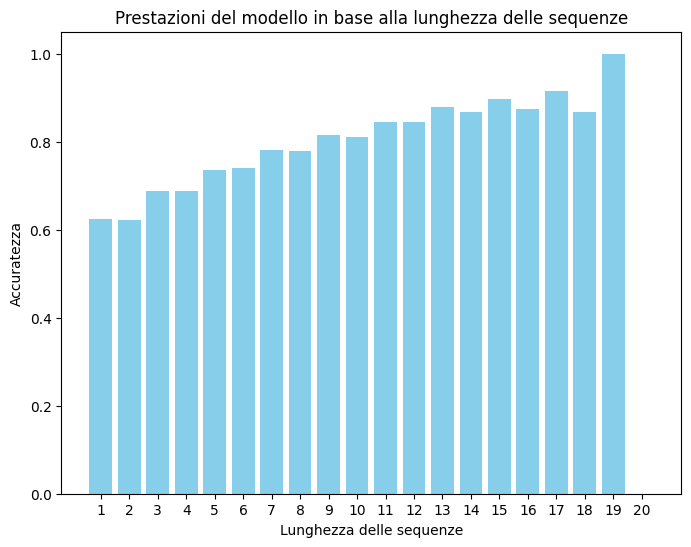

In [ ]:
plt.figure(figsize=(8, 6))
# Aggiusta per visualizzare le lunghezze come numeri e l'accuratezza associata
lengths = list(range(1, 21))  # Lunghezze da 1 a 19
accuracies = [performance_by_length.get(str(length), 0) for length in lengths]  # Ottieni accuracies o 0 se non ci sono dati

plt.bar(lengths, accuracies, color='skyblue')
plt.xlabel('Lunghezza delle sequenze')
plt.ylabel('Accuratezza')
plt.title('Prestazioni del modello in base alla lunghezza delle sequenze')
plt.xticks(lengths)  # Mostra tutte le lunghezze sull'asse x
plt.show()

Notiamo che il modello adesso che è stato allenato senza i casi in cui si arriva ai vantaggi presenta una diversificazione minore dei casi 6-4 con sequenze opposte

In [ ]:
# Previsione
test_sequences = [[1,1,1,1,1,1,1,1,0,0,0,0],
                  [1,0,1,0,1,0,1,1,0,1,1,1]]
padded_test_sequences = pad_sequences(
    test_sequences,
    maxlen = 19,
    padding ='post',
    truncating ='post',
    value = -1
)

padded_test_sequences.shape

(2, 19)

In [ ]:
probabilità = model.predict(padded_test_sequences)

# La probabilità per la classe 1 (output di sigmoid)
print(probabilità[1][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0.95398754


LSTM versione con iperparametri modificati(capire se funziona meglio dell'altra versione e capire perchè
funziona anche se metto input_dim=2 però ci sono 3 valori considerando l'embedding, capire anche se il parametro mask_Zero serve)
Dai testing noto che l'accuracy peggiore ma potrebbe migliorare la generalizzazione

Valutare se considerarla

In [ ]:
'''
Test LSTM con parametri utili
'''
# Assicurati che 'player_points' sia una lista di interi
player_points = np.array(dataset['player_points'].values)
set_result = np.array(dataset['set_result'].values)  # Target binari

X_train, X_val, Y_train, Y_val = train_test_split(player_points, set_result, test_size=0.2, random_state=42)
X_train = pad_sequences(X_train, maxlen=19, padding='post', truncating='post', value=-1)
X_val = pad_sequences(X_val, maxlen=19, padding='post', truncating='post', value=-1)

# Reshape del target
Y_train = Y_train.reshape(-1, 1)
Y_val = Y_val.reshape(-1, 1)

model = Sequential([
    Embedding(input_dim=2, output_dim=64),  # Embedding layer (2 valori, 64 neuroni)
    LSTM(128, return_sequences=False),  # LSTM con 128 neuroni
    Dropout(0.5),  # Aggiungi Dropout per evitare overfitting
    Dense(64, activation='relu'),  # Aggiungi un layer Dense intermedio
    Dense(1, activation='sigmoid')  # Output layer per la classificazione binaria
])

# Compilazione del modello
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_train, Y_train, epochs=20, batch_size=128, validation_data=(X_val, Y_val), callbacks=[early_stopping])

KeyboardInterrupt: 

Modello LSTM con tutte le feature(dalle prestazioni si nota che le nuove feature non danno miglioramenti)

In [ ]:
'''
Test LSTM con tutte le feature
'''

# Supponiamo che tu abbia un DataFrame chiamato dataset
# Estrai le sequenze (player_points)
player_points = np.array(dataset['player_points'].values)  # Assicurati che sia un array numpy

# Estrai il target
set_result = np.array(dataset['set_result'].values)  # Target binario

# Estrai le feature globali (6 feature binarie)
global_features = np.array(dataset[['players_gender_M'	,'players_gender_W',	'players_gender_X','is_final', 'final_set', 'opponent_final_set']])

# Padding delle sequenze
max_sequence_length = 19      #Impostare a 20 se si considerano i vantaggi
player_points_padded = pad_sequences(player_points, maxlen=max_sequence_length, padding='post', truncating='post', value=-1)

# Train/test split
X_train_seq, X_test_seq, Y_train, Y_test, X_train_global, X_test_global = train_test_split(
    player_points_padded, set_result, global_features, test_size=0.2, random_state=42, stratify=set_result
)

# Modello
# Input per sequenze
sequence_input = Input(shape=(max_sequence_length,), name='sequence_input')
x = Embedding(input_dim=3, output_dim=32)(sequence_input)
x = LSTM(64, return_sequences=True)(x)
x = LSTM(32, return_sequences=False)(x)

# Input per feature globali
global_input = Input(shape=(6,), name='global_input')  # 6 feature binarie
global_dense = Dense(16, activation='relu')(global_input)

# Combina i due input
combined = concatenate([x, global_dense])
x = Dropout(0.3)(combined)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Costruisci il modello
model = Model(inputs=[sequence_input, global_input], outputs=output)

# Compila il modello
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Allenamento
model.fit([X_train_seq, X_train_global], Y_train, epochs=5, batch_size=128)

# Valutazione
loss, accuracy = model.evaluate([X_test_seq, X_test_global], Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")


Epoch 1/5
12147/12147 ━━━━━━━━━━━━━━━━━━━━ 107s 8ms/step - accuracy: 0.7835 - loss: 0.4361
Epoch 2/5
12147/12147 ━━━━━━━━━━━━━━━━━━━━ 101s 8ms/step - accuracy: 0.7887 - loss: 0.4230
Epoch 3/5
12147/12147 ━━━━━━━━━━━━━━━━━━━━ 143s 8ms/step - accuracy: 0.7894 - loss: 0.4214
Epoch 4/5
12147/12147 ━━━━━━━━━━━━━━━━━━━━ 101s 8ms/step - accuracy: 0.7897 - loss: 0.4208
Epoch 5/5
12147/12147 ━━━━━━━━━━━━━━━━━━━━ 143s 8ms/step - accuracy: 0.7900 - loss: 0.4210
Test Loss: 0.4191, Test Accuracy: 0.7911


In [ ]:
performance_by_length = {}
X_test_seq_filtered = [[elem for elem in seq if elem != -1] for seq in X_test_seq]
sequence_lengths = [len(seq) for seq in X_test_seq_filtered]

# Itera per lunghezze di sequenza da 1 a 20
for length in range(1, 21):  # Lunghezze da 1 a 20
    # Ottieni gli indici delle sequenze con lunghezza `length`
    indices = [idx for idx, seq_length in enumerate(sequence_lengths) if seq_length == length]

    if indices:  # Procedi solo se ci sono sequenze con quella lunghezza
        # Filtra le sequenze, i target e le feature globali corrispondenti
        X_subset = np.array([X_test_seq[idx] for idx in indices])
        Y_subset = np.array([Y_test[idx] for idx in indices])
        X_global_subset = np.array([X_test_global[idx] for idx in indices])

        # Assicurati che le sequenze abbiano la lunghezza corretta (es. padding/truncating)
        X_subset_padded = pad_sequences(X_subset, maxlen=19, padding='post', truncating='post', value=-1)

        # Concatena le sequenze locali (padded) e globali

        # Predici i risultati
        Y_pred_subset = model.predict([X_subset_padded, X_global_subset])
        Y_pred_binary_subset = (Y_pred_subset > 0.5).astype(int)

        # Calcola l'accuratezza
        accuracy = accuracy_score(Y_subset, Y_pred_binary_subset)
        performance_by_length[f"{length}"] = accuracy

743/743 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
735/735 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
740/740 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
740/740 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
747/747 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
743/743 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
742/742 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
739/739 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
743/743 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
746/746 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
712/712 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
665/665 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
596/596 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
510/510 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


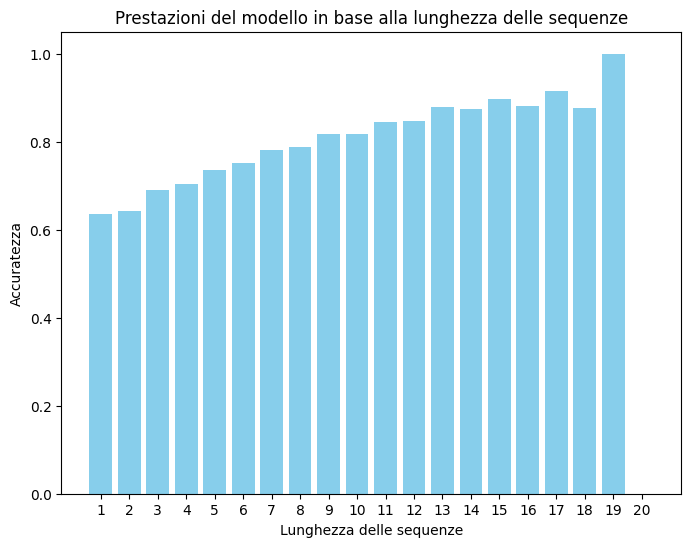

In [ ]:
plt.figure(figsize=(8, 6))
# Aggiusta per visualizzare le lunghezze come numeri e l'accuratezza associata
lengths = list(range(1, 21))  # Lunghezze da 1 a 19
accuracies = [performance_by_length.get(str(length), 0) for length in lengths]  # Ottieni accuracies o 0 se non ci sono dati

plt.bar(lengths, accuracies, color='skyblue')
plt.xlabel('Lunghezza delle sequenze')
plt.ylabel('Accuratezza')
plt.title('Prestazioni del modello in base alla lunghezza delle sequenze')
plt.xticks(lengths)  # Mostra tutte le lunghezze sull'asse x
plt.show()

## Regressione Logistica
Utilizziamo un modello di regressione logistica

COSA FA QUESTA FUNZIONE e Perchè ci serve

In [ ]:
'''
Si creano n =len(points) righe per ciascun set del dataset
'''

def generate_score_sequence(player_points):
    # Se player_points è vuoto o non valido, restituiamo una lista vuota (evitando righe nulle)
    if not player_points:
        return []

    # Crea una sequenza delle liste
    sequence = [list(map(int, player_points[:i])) for i in range(1, len(player_points) + 1)]  # Liste di interi
    return sequence

# Generiamo e esplodiamo la colonna
dataset['player_points'] = dataset['player_points'].apply(generate_score_sequence)

# Rimuoviamo righe con sequenze vuote, che potrebbero causare righe con valori nulli
dataset = dataset[dataset['player_points'].apply(len) > 0]

# Esplodiamo la colonna 'player_points'
dataset = dataset.explode('player_points', ignore_index=True)

# Mostriamo il risultato finale
dataset

,players_gender_M,players_gender_W,players_gender_X,is_final,final_set,opponent_final_set,player_points,set_result
0,0,1,0,1,0,0,[0],0
1,0,1,0,1,0,0,"[0, 0]",0
2,0,1,0,1,0,0,"[0, 0, 1]",0
3,0,1,0,1,0,0,"[0, 0, 1, 2]",0
4,0,1,0,1,0,0,"[0, 0, 1, 2, 2]",0
...,...,...,...,...,...,...,...,...
2414867,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7]",1
2414868,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8]",1
2414869,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9]",1
2414870,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9, 9]",1


COSA FA QUESTA FUNZIONE e PERCHE' ci servef

In [ ]:
# Funzione per calcolare le caratteristiche
def calculate_features(player_points):
    sum_values = sum(player_points)  # Somma dei valori
    num_values = len(player_points)  # Lunghezza (numero totale di valori)

    # Calcolo duplicati (numero di valori che appaiono più di una volta)
    if player_points[0] == 0:
      num_duplicates = 1 + sum(count - 1 for count in Counter(player_points).values() if count > 1)
    else:
      num_duplicates = sum(count - 1 for count in Counter(player_points).values() if count > 1)

    # Calcolo entropia
    entropy = -sum((count / num_values) * math.log2(count / num_values) for count in Counter(player_points).values() if count > 0)

    return num_values, num_duplicates, entropy, sum_values

# Funzione per applicare i calcoli al DataFrame
def process_dataset(dataset):
    num_values_list = []
    num_duplicates_list = []
    entropy_list = []
    sum_list = []

    # Ciclo per ogni lista di player_points nel dataset
    for player_points in dataset['player_points']:
      if isinstance(player_points, list):
        num_values, num_duplicates, entropy, sum_values = calculate_features(player_points)
        num_values_list.append(num_values)
        num_duplicates_list.append(num_duplicates)
        entropy_list.append(entropy)
        sum_list.append(sum_values)

    # Aggiungiamo i risultati al dataset
    dataset['num_values'] = num_values_list
    dataset['num_duplicates'] = num_duplicates_list
    dataset['entropy'] = entropy_list
    dataset['sum_values'] = sum_list

    return dataset

# Applicazione del calcolo al DataFrame
dataset = process_dataset(dataset)

# Riorganizzare le colonne per posizionarle dopo player_points
player_points_index = dataset.columns.get_loc('player_points')

# Inseriamo le nuove colonne subito dopo 'player_points'
dataset.insert(player_points_index + 1, 'num_values',  dataset.pop('num_values'))
dataset.insert(player_points_index + 2, 'num_duplicates', dataset.pop('num_duplicates'))
dataset.insert(player_points_index + 3, 'entropy', dataset.pop('entropy'))
dataset.insert(player_points_index + 4, 'sum_values',  dataset.pop('sum_values'))

# Mostra il DataFrame risultante
dataset

,players_gender_M,players_gender_W,players_gender_X,is_final,final_set,opponent_final_set,player_points,num_values,num_duplicates,entropy,sum_values,set_result
0,0,1,0,1,0,0,[0],1,1,-0.000000,0,0
1,0,1,0,1,0,0,"[0, 0]",2,2,-0.000000,0,0
2,0,1,0,1,0,0,"[0, 0, 1]",3,2,0.918296,1,0
3,0,1,0,1,0,0,"[0, 0, 1, 2]",4,2,1.500000,3,0
4,0,1,0,1,0,0,"[0, 0, 1, 2, 2]",5,3,1.521928,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2414867,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7]",12,5,2.855389,43,1
2414868,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8]",13,5,3.026987,51,1
2414869,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9]",14,5,3.182006,60,1
2414870,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9, 9]",15,6,3.189898,69,1


Adesso inizializza il dataset X e le feature Y. Non considera, il Gender per la troppa poca importanza

In [ ]:
X = np.array((dataset[['players_gender_M'	,'players_gender_W',	'players_gender_X','is_final', 'final_set', 'opponent_final_set','num_values', 'num_duplicates', 'entropy', 'sum_values']].values))

#X = np.array((dataset[['num_values', 'num_duplicates', 'entropy', 'sum_values']].values))

Y = np.array(dataset['set_result'].values)  # Target binari

Scaling

In [ ]:
# Impostare il K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

Accuracy: 0.74
              precision    recall  f1-score   support

           0       0.73      0.75      0.74    240729
           1       0.75      0.73      0.74    242246

    accuracy                           0.74    482975
   macro avg       0.74      0.74      0.74    482975
weighted avg       0.74      0.74      0.74    482975



Valutiamo l'importanza delle feature con un Random Forest

In [ ]:
# Addestra un modello di esempio
rf_model = RandomForestClassifier(random_state=42)

# Variabili per raccogliere i risultati della cross-validation
feature_importances = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    rf_model.fit(X_train, Y_train)

    # Importanza delle feature
    importances = rf_model.feature_importances_
    feature_importances.append(importances)

# Media delle importanze delle feature
mean_importances = np.mean(feature_importances, axis=0)

feature_names = ['players_gender_M', 'players_gender_W', 'players_gender_X', 'is_final',
                 'final_set', 'opponent_final_set', 'num_values', 'num_duplicates', 'entropy', 'sum_values']



<ipython-input-28-b38a240a4287>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y= ['players_gender_M', 'players_gender_W', 'players_gender_X', 'is_final',


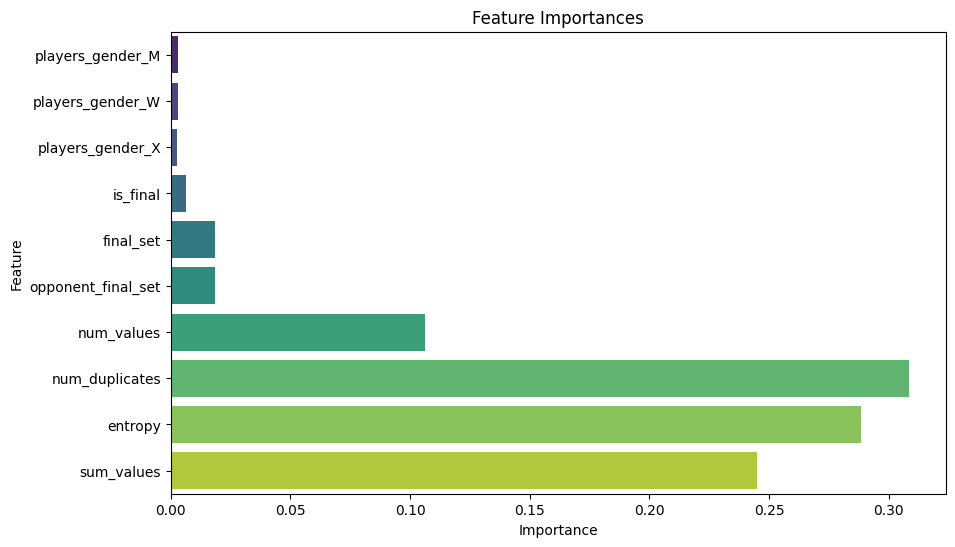

In [ ]:
# Visualizzazione
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_importances, y=feature_names, palette="viridis")
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [ ]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

accuracies = []
classification_reports = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    # Addestramento
    logreg_model.fit(X_train, Y_train)

    # Predizioni
    Y_pred = logreg_model.predict(X_test)
    Y_pred_prob = logreg_model.predict_proba(X_test)

    # Valutazione
    accuracy = accuracy_score(Y_test, Y_pred)
    accuracies.append(accuracy)
    classification_reports.append(classification_report(Y_test, Y_pred))

# Media delle performance
mean_accuracy = np.mean(accuracies)
print(f"Accuracy media: {mean_accuracy:.2f}")

print(classification_reports[0])

Creo dei testcase personalizzati

In [ ]:
# Sequenze di test

test_seq = np.array([[1,1,1,1,1,2,3,4,5],
                     [0,1,2,3,4,5,5,5,5],
                     [0,1,2,3,4,5,6,7,8],
                     [0,0,0,1,1,1,2,2,2]])  # Punti del giocatore

def calculate_features(player_points):
    sum_values = sum(player_points)  # Somma dei valori
    num_values = len(player_points)  # Lunghezza (numero totale di valori)

    # Calcolo duplicati (numero di valori che appaiono più di una volta)
    if player_points[0] == 0:
      num_duplicates = 1 + sum(count - 1 for count in Counter(player_points).values() if count > 1)
    else:
      num_duplicates = sum(count - 1 for count in Counter(player_points).values() if count > 1)

    # Calcolo entropia
    entropy = -sum((count / num_values) * math.log2(count / num_values) for count in Counter(player_points).values() if count > 0)

    return num_values, num_duplicates, entropy, sum_values

num_values_list = []
num_duplicates_list = []
entropy_list = []
sum_values_list = []  # Cambiato il nome della variabile per evitare conflitti con la funzione sum()

for seq in test_seq:
    num_values, num_duplicates, entropy, sum_values = calculate_features(seq)
    num_values_list.append(num_values)
    num_duplicates_list.append(num_duplicates)
    entropy_list.append(entropy)
    sum_values_list.append(sum_values)  # Usato sum_values_list, non sum

# Creare un nuovo array con i valori calcolati
test_seq_updated = np.array([num_values_list, num_duplicates_list, entropy_list, sum_values_list]).T

# Aggiunta eventuali feature aggiuntive
extra_values = np.array([[1, 0, 0, 0, 0, 0]] * test_seq_updated.shape[0])
test_seq_updated = np.hstack((extra_values, test_seq_updated))

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  9.        ,  4.        ,  1.87996495, 19.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  9.        ,  4.        ,  2.28103611, 30.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  9.        ,  1.        ,  3.169925  , 36.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  9.        ,  7.        ,  1.5849625 ,  9.        ]])

In [ ]:
'''
Il modello non riesce a generalizzare considerando le intere sequenze,
per questo motivo abbiamo deciso di considerare come feature di addestramento
il numero di valori, la somma, il numero di duplicati e l'entropia applicate
su tutte le istanze dei vari set(le sequenze)

In questo modo il modello riesce a predire bene casi semplici
ma non riesce a generalizzare casi più complessi come rimonte intermedie

Inoltre abbiamo notato che l'aggiunta delle feature relative alla tipologia
di set peggiorano in molti casi le prestazioni del modello, questo perchè
ci sono molte combinazioni di queste feature rare. Per esempio un set finale
di una finale di torneo giocata da un gender X
'''

# Concatenare le due parti per formare il caso di test finale
#X_test_case_concate = [np.concatenate([x_bin, seq]) for x_bin, seq in zip(test_bin, test_seq)]
#X_test_case = np.array(X_test_case_concate)

X_test_case = scaler.transform(test_seq_updated)

# Concatenare le due parti per formare il caso di test finale
probabilities = logreg_model.predict_proba([X_test_case[0]])

prob_class_1 = probabilities[0][1]
prob_class_0 = probabilities[0][0]


print(f"Probabilità di vincere (classe 1): {prob_class_1:.4f}")
print(f"Probabilità di perdere (classe 0): {prob_class_0:.4f}")

Probabilità di vincere (classe 1): 0.6435
Probabilità di perdere (classe 0): 0.3565
